In [14]:
import sys, os
sys.path.insert(0, os.getcwd())
sys.path.insert(0, os.path.dirname(os.getcwd()))
from isi_corr import *
from random import sample

In [2]:
test_data_root = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "R_DATA_UnitMatch")
mt_path = os.path.join(test_data_root, "AL036", "19011116882", "3", "new_matchtable.csv")   
dnn_metric = "DNNSim"
um_metric = "MatchProb"
mt = pd.read_csv(mt_path)
thresh = dnn_dist.get_threshold(mt, metric=dnn_metric, vis=False)
if um_metric=="MatchProb":
    thresh_um=0.5
else:
    if um_metric=="ScoreExclCentroid":
        col = mt.loc[:, "WavformSim":"LocTrajectorySim"]
        mt[um_metric] = col.mean(axis=1)
    thresh_um = dnn_dist.get_threshold(mt, metric=um_metric, vis=False)
within = mt.loc[(mt["RecSes1"]==mt["RecSes2"]), [dnn_metric, "ISICorr", "ID1", "ID2", um_metric]]                                              # Only keep within-day bits
across = mt.loc[(mt["RecSes1"]!=mt["RecSes2"]), [dnn_metric, "ISICorr", um_metric, "RecSes1", "RecSes2", "ID1", "ID2"]]                        # Only keep across-day bits

# Correct for different median similarities between within- and across-day sets.
diff = np.median(within[dnn_metric]) - np.median(across[dnn_metric])
thresh = thresh - diff

diff_um = np.median(within[um_metric])- np.median(across[um_metric])
thresh_um = thresh_um - diff_um

matches_across = across.loc[mt[dnn_metric]>=thresh, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2"]]
non_matches = within.loc[(mt["ID1"]!=mt["ID2"]), ["ISICorr"]]
same_within = within.loc[(mt["ID1"]==mt["ID2"]), ["ISICorr"]]

um_matches = across.loc[mt[um_metric]>=thresh_um, ["ISICorr"]]

In [3]:
exp_ids, metadata = mtpath_to_expids(mt_path, matches_across)
test_data_root = mt_path[:mt_path.find(metadata["mouse"])]
positions = {}
for recses, exp_id in exp_ids.items():
    fp = os.path.join(test_data_root, metadata["mouse"], metadata["probe"], 
                        metadata["loc"], exp_id, "processed_waveforms")
    pos_dict = read_pos(fp)
    positions[recses] = pd.DataFrame(pos_dict)

In [4]:
corrections = get_corrections(matches_across, positions)

In [5]:
matches = matches_across


In [6]:
mt_path = os.path.join(test_data_root, "AL036", "19011116882", "3", "new_matchtable.csv")

100%|██████████| 6/6 [00:20<00:00,  3.36s/it]


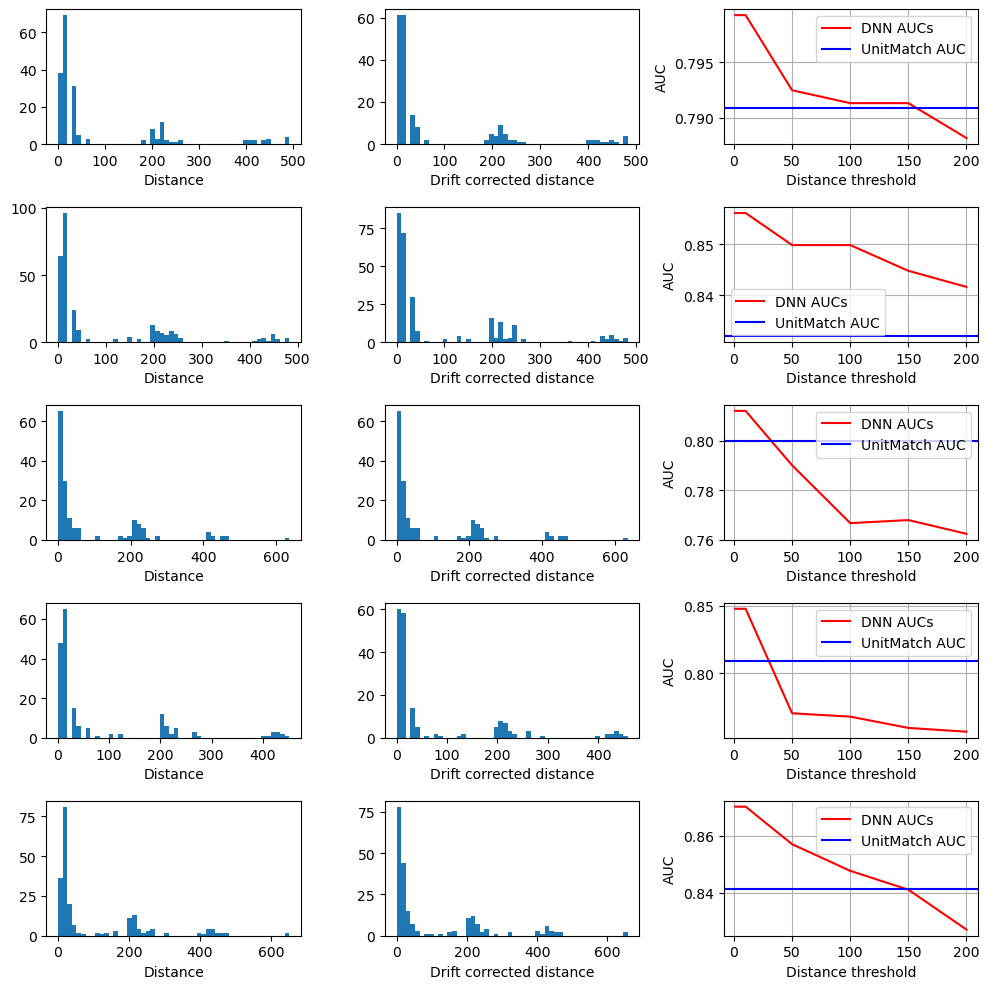

In [18]:
sessions = set(matches["RecSes1"].unique())
sessions = list(sessions.union(set(matches["RecSes2"].unique())))
mt = pd.read_csv(mt_path)
thresholds = [1,10,50,100,150,200]
fig, axs = plt.subplots(nrows=5, ncols=3, figsize = (10,10))
i = 0
while i < 5:
    aucs = []
    r1 = sample(sessions,1)[0]
    r2 = sample(sessions,1)[0]
    while r2 == r1:
        r2 = sample(sessions,1)[0]
    for t in tqdm(thresholds):
        dnn, um = auc_one_pair(mt, r1, r2, dist_thresh=t, mt_path=mt_path)
        while dnn is None or um is None:
            r1 = sample(sessions,1)[0]
            r2 = sample(sessions,1)[0]
            while r2 == r1:
                r2 = sample(sessions,1)[0]
            dnn, um = auc_one_pair(mt, r1, r2, dist_thresh=t, mt_path=mt_path)
        aucs.append(dnn)
    dists=plot_distances(matches, positions, r1, r2, None)
    dists_dc=plot_distances(matches, positions, r1, r2, corrections)
    axs[i,0].hist(dists, bins=50)
    axs[i,0].set_xlabel("Distance")
    axs[i,1].hist(dists_dc, bins=50)
    axs[i,1].set_xlabel("Drift corrected distance")
    axs[i,2].plot(thresholds, aucs, color = "r", label="DNN AUCs")
    axs[i,2].axhline(um, label="UnitMatch AUC", color="b")
    axs[i,2].set_ylabel("AUC")
    axs[i,2].grid()
    axs[i,2].set_xlabel("Distance threshold")
    axs[i,2].legend(loc="best")
    i +=1
    fig.tight_layout()
plt.show()